In [1]:
import numpy as np
import pandas as pd
import json
from pprint import pp
import tldextract
from scipy import stats

from retrieval_importance import learn_importance, encode_retrievals, encode_groups, v_grouped, \
    most_important_groups, least_important_groups

np.random.seed(7334)

k = 10
validation_fraction = 0.33

In [2]:
#application = 'imputation' #
#task = 'restaurant'

application = 'question_answering'
task = 'wikifact__genre'

retrievals = []

with open(f'./applications/{application}/{task}.jsonl') as file:
    for line in file:
        retrievals.append(json.loads(line))

In [3]:
pp(retrievals[5], width=100, compact=True)

{'question': 'The genre of Zettai Zetsumei is a/an',
 'correct_answers': ['J-pop', 'Japanese pop', 'jpop', 'Japanese popular music'],
 'retrieved_answers': ['heavy metal', 'action adventure', 'traditional folk music',
                       'traditional folk music', 'traditional folk music', 'traditional folk music',
                       'comedy', 'instrumental', 'shounen, fantasy, supernatural, gender b',
                       'manga', 'doujinshi', 'traditional folk music', 'traditional folk music',
                       'classical music', 'rock music', 'traditional folk music',
                       'traditional folk music', 'horror', 'action', 'traditional folk music',
                       'shounen manga', 'traditional folk music', 'comedy', 'adventure game',
                       'alternative rock', 'traditional folk music', 'traditional folk music',
                       'traditional folk music', 'action, adventure, role-playing, strategy,',
                       'action

In [4]:
np.random.shuffle(retrievals)

split_index = int(len(retrievals) * validation_fraction)
validation, test = retrievals[:split_index], retrievals[split_index:]

In [5]:
def utility(retrieval, prediction):
    if prediction in retrieval["correct_answers"]:
        return 1.0
    else:
        return 0.0

In [6]:
def group(retrieved):    
    url_parts = tldextract.extract(retrieved)
    return f'{url_parts.domain}.{url_parts.suffix}'

In [7]:
encoded_retrievals, mapping = encode_retrievals(validation, "retrieved_websites", "retrieved_answers", utility)
grouping, group_mapping = encode_groups(mapping, group)

In [8]:
weights = learn_importance(encoded_retrievals, k=k, learning_rate=10, num_steps=100, n_jobs=-1, grouping=grouping)

In [9]:
source_weights = v_grouped(weights, grouping, group_mapping)

In [10]:
most_important_groups(source_weights, 10)

[('alchetron.com', 1.0),
 ('allmusic.com', 1.0),
 ('bandnext.com', 1.0),
 ('everipedia.org', 1.0),
 ('imdb.com', 1.0),
 ('peoplepill.com', 1.0),
 ('wiki2.org', 1.0),
 ('wikiwand.com', 1.0),
 ('wikipedia.org', 0.9997276602099302),
 ('filmaffinity.com', 0.9777853865563869)]

In [11]:
least_important_groups(source_weights, 10)

[('cbr.com', 0.0),
 ('coursementor.com', 0.0),
 ('discogs.com', 0.0),
 ('enotes.com', 0.0),
 ('goodreads.com', 0.0),
 ('merriam-webster.com', 0.0),
 ('qobuz.com', 0.0),
 ('quizlet.com', 0.0),
 ('quora.com', 0.0),
 ('hitparade.ch', 0.001592945006189497)]

In [12]:
def pruned_prediction(sample, utility, k, threshold, source_weights):
    predictions_with_sources = zip(sample['retrieved_answers'], sample['retrieved_websites'])

    pruned_predictions = [prediction for prediction, source in predictions_with_sources if
                          source not in source_weights or source_weights[source] >= threshold]

    pruned_predictions = pruned_predictions[:k]

    mode = max(set(pruned_predictions), key=pruned_predictions.count)

    return utility(sample, mode)


def evaluate(samples, utility, k, threshold, source_weights, normalize=False):
    aggregate_utility = 0.0

    for sample in samples:
        aggregate_utility += pruned_prediction(sample, utility, k, threshold, source_weights)

    if normalize:    
        return aggregate_utility / len(samples)        
    else:        
        return aggregate_utility

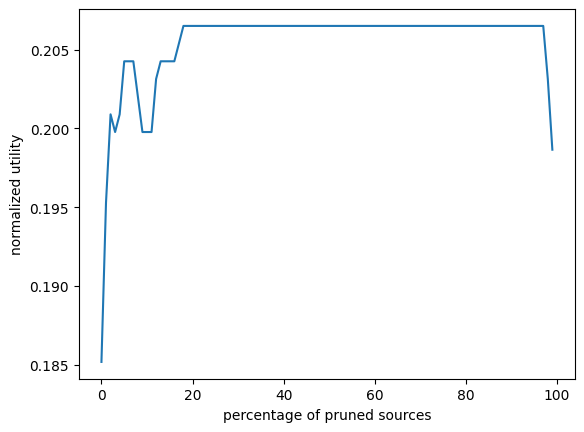

Found best (normalized) utility of 0.20650953984287318 on validation set with threshold 0.572293340364702, removing 97 percent of sources


In [13]:
best_utility = 0.0
best_threshold = 0.0
best_percentile = 0

achieved_utilities = []

percentile_range = range(0, 100, 1)

for percentile in percentile_range:
    threshold = np.percentile(list(source_weights.values()), percentile)

    achieved_utility = evaluate(validation, utility, k, threshold, source_weights, normalize=True)  
    
    achieved_utilities.append(achieved_utility)
    
    if achieved_utility >= best_utility:
        best_utility = achieved_utility
        best_threshold = threshold
        best_percentile = percentile        

import matplotlib.pyplot as plt

plt.plot(percentile_range, achieved_utilities)     
plt.ylabel('normalized utility')
plt.xlabel('percentage of pruned sources')
plt.show()
        
print(f'Found best (normalized) utility of {best_utility} on validation set with threshold {best_threshold}, ' + 
      f'removing {best_percentile} percent of sources')        

In [14]:
evaluate(test, utility, k, 0.0, source_weights, normalize=True)

0.14096185737976782

In [15]:
evaluate(test, utility, k, best_threshold, source_weights, normalize=True)

0.1564400221116639